### Introduction to Machine Learning: Clustering
#### Corey Solitaire
#### 10/09/2020

In [1]:
import acquire
import prepare
# import src.explore
# import src.model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### Acquire & Summarize

**1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.**

    - Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
    - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
    - Only include properties that include a latitude and longitude value.

In [2]:
# Acquire df
df = acquire.get_zillow_data(cached=True)
pd.set_option('display.max_rows', df.shape[0]+1) # Shows all the rows

In [3]:
df.shape

(77381, 70)

In [4]:
# Rename duplicate column id/id with id_delete/id
df.columns = ['parcelid', 'typeconstructiontypeid', 'storytypeid',
       'propertylandusetypeid', 'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id_delete',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear',
       'censustractandblock', 'id', 'logerror', 'pid', 'tdate',
       'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc',
       'heatingorsystemdesc', 'propertylandusedesc', 'storydesc',
       'typeconstructiondesc']

In [5]:
# Delete duplicate columns id_delete and pid (dupilcate of parcelid)
df.drop(columns = ['id_delete','pid'], inplace = True)
df.shape

(77381, 68)

***

**2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)**

***

In [6]:
def df_summary(df):
    print('The shape of the df:') 
    print(df.shape)  # df shape (row/column)
    print('\n')
    print('Columns, Non-Null Count, Data Type:')
    print(df.info())      # Column, Non Null Count, Data Type
    print('\n')
    print('Summary statistics for the df:') 
    print(df.describe())             # Summary Statistics on Numeric Data Types
    print('\n')
    print('Number of NaN values per column:') 
    print(df.isna().sum())           # NaN by column
    print('\n')
    print('Number of NaN values per row:')  
    print(df.isnull().sum(axis=1))   # NaN by row
    print('\n')
    print('Value Counts per Column:')
    for col in df.columns:
        print('-' * 40 + col + '-' * 40 , end=' - ')
        display(df[col].value_counts(dropna=False).head(10))
        #display(df_resp[col].value_counts())  # Displays all Values, not just First 10

In [7]:
df_summary(df)

The shape of the df:
(77381, 68)


Columns, Non-Null Count, Data Type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77381 non-null  float64
 4   heatingorsystemtypeid         49440 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   basementsqft                  50 non-null     float64
 9   bathroomcnt                   77381 non-null  float64
 10  bedroomcnt                    77381 non-null  float64
 11  buildingqualitytypeid         49672 non-null  fl

0        36
1        33
2        34
3        32
4        29
5        33
6        29
7        35
8        34
9        31
10       29
11       40
12       36
13       32
14       38
15       33
16       34
17       31
18       34
19       37
20       30
21       34
22       35
23       33
24       31
25       33
26       31
27       31
28       33
29       34
30       32
31       34
32       33
33       32
34       37
35       32
36       33
37       43
38       29
39       37
40       37
41       31
42       31
43       33
44       33
45       31
46       31
47       36
48       30
49       31
50       36
51       32
52       36
53       31
54       32
55       32
56       35
57       32
58       37
59       38
60       36
61       33
62       33
63       34
64       38
65       32
66       35
67       33
68       33
69       30
70       33
71       31
72       31
73       34
74       37
75       33
76       32
77       30
78       32
79       35
80       32
81       30
82       29
83  

12086286    1
13842812    1
17089101    1
14604878    1
11149905    1
12104347    1
11077074    1
17173076    1
12714581    1
12458582    1
Name: parcelid, dtype: int64

----------------------------------------typeconstructiontypeid---------------------------------------- - 

NaN     77159
6.0       219
4.0         1
13.0        1
10.0        1
Name: typeconstructiontypeid, dtype: int64

----------------------------------------storytypeid---------------------------------------- - 

NaN    77331
7.0       50
Name: storytypeid, dtype: int64

----------------------------------------propertylandusetypeid---------------------------------------- - 

261.0    52320
266.0    19294
246.0     2009
269.0     1944
248.0      727
247.0      535
265.0      333
263.0       74
275.0       58
260.0       37
Name: propertylandusetypeid, dtype: int64

----------------------------------------heatingorsystemtypeid---------------------------------------- - 

2.0     33550
NaN     27941
7.0     14065
24.0      846
6.0       776
20.0      104
13.0       59
18.0       23
1.0        13
10.0        3
Name: heatingorsystemtypeid, dtype: int64

----------------------------------------buildingclasstypeid---------------------------------------- - 

NaN    77366
4.0       14
3.0        1
Name: buildingclasstypeid, dtype: int64

----------------------------------------architecturalstyletypeid---------------------------------------- - 

NaN     77175
7.0       172
8.0        19
21.0        7
2.0         5
3.0         3
Name: architecturalstyletypeid, dtype: int64

----------------------------------------airconditioningtypeid---------------------------------------- - 

NaN     52428
1.0     23133
13.0     1574
5.0       167
11.0       53
9.0        26
Name: airconditioningtypeid, dtype: int64

----------------------------------------basementsqft---------------------------------------- - 

NaN      77331
700.0        2
515.0        2
900.0        2
912.0        2
640.0        2
273.0        2
100.0        2
669.0        1
252.0        1
Name: basementsqft, dtype: int64

----------------------------------------bathroomcnt---------------------------------------- - 

2.0    31485
3.0    17313
1.0    12902
2.5     6604
4.0     3352
1.5     1415
3.5     1034
5.0     1026
4.5      695
0.0      592
Name: bathroomcnt, dtype: int64

----------------------------------------bedroomcnt---------------------------------------- - 

3.0    30362
2.0    19169
4.0    17513
5.0     4543
1.0     3379
6.0      998
0.0      830
8.0      252
7.0      208
9.0       70
Name: bedroomcnt, dtype: int64

----------------------------------------buildingqualitytypeid---------------------------------------- - 

NaN     27709
8.0     14645
6.0     13462
4.0      9483
7.0      5971
9.0      2299
5.0      2088
11.0      931
3.0       329
10.0      313
Name: buildingqualitytypeid, dtype: int64

----------------------------------------calculatedbathnbr---------------------------------------- - 

2.0    31485
3.0    17313
1.0    12902
2.5     6595
4.0     3352
1.5     1408
3.5     1034
5.0     1026
4.5      695
NaN      609
Name: calculatedbathnbr, dtype: int64

----------------------------------------decktypeid---------------------------------------- - 

NaN     76767
66.0      614
Name: decktypeid, dtype: int64

----------------------------------------finishedfloor1squarefeet---------------------------------------- - 

NaN       71358
1252.0       22
1498.0       21
1441.0       21
780.0        21
1462.0       21
1205.0       21
1070.0       20
1227.0       19
1431.0       18
Name: finishedfloor1squarefeet, dtype: int64

----------------------------------------calculatedfinishedsquarefeet---------------------------------------- - 

NaN       196
1200.0    181
1120.0    169
1440.0    147
1080.0    132
1260.0    120
1176.0    119
1300.0    118
1040.0    118
1232.0    117
Name: calculatedfinishedsquarefeet, dtype: int64

----------------------------------------finishedsquarefeet12---------------------------------------- - 

NaN       3632
1200.0     176
1120.0     165
1080.0     131
1440.0     120
1232.0     116
1260.0     116
1040.0     116
1300.0     114
1570.0     114
Name: finishedsquarefeet12, dtype: int64

----------------------------------------finishedsquarefeet13---------------------------------------- - 

NaN       77340
1440.0       18
1344.0        5
1488.0        3
1536.0        3
1248.0        2
1152.0        2
1392.0        2
1512.0        1
1200.0        1
Name: finishedsquarefeet13, dtype: int64

----------------------------------------finishedsquarefeet15---------------------------------------- - 

NaN       74372
1680.0       16
1536.0       12
2016.0       12
1600.0       10
1440.0        9
1560.0        9
1512.0        9
1740.0        8
1584.0        8
Name: finishedsquarefeet15, dtype: int64

----------------------------------------finishedsquarefeet50---------------------------------------- - 

NaN       71358
1252.0       22
1462.0       21
1441.0       21
780.0        21
1205.0       21
1498.0       21
1070.0       20
1227.0       19
1431.0       18
Name: finishedsquarefeet50, dtype: int64

----------------------------------------finishedsquarefeet6---------------------------------------- - 

NaN       76995
952.0         4
750.0         3
3500.0        3
3552.0        3
520.0         3
4300.0        2
1539.0        2
4213.0        2
2110.0        2
Name: finishedsquarefeet6, dtype: int64

----------------------------------------fips---------------------------------------- - 

6037.0    50551
6059.0    20593
6111.0     6237
Name: fips, dtype: int64

----------------------------------------fireplacecnt---------------------------------------- - 

NaN    69105
1.0     7008
2.0      995
3.0      235
4.0       35
5.0        3
Name: fireplacecnt, dtype: int64

----------------------------------------fullbathcnt---------------------------------------- - 

2.0    38097
3.0    18351
1.0    14310
4.0     4048
5.0     1245
NaN      609
6.0      454
7.0      121
8.0      111
9.0       23
Name: fullbathcnt, dtype: int64

----------------------------------------garagecarcnt---------------------------------------- - 

NaN     51907
2.0     18608
1.0      5676
3.0       632
4.0       255
0.0       230
5.0        45
6.0        14
7.0         4
10.0        3
Name: garagecarcnt, dtype: int64

----------------------------------------garagetotalsqft---------------------------------------- - 

NaN      51907
0.0       7685
400.0      786
441.0      678
462.0      658
360.0      646
460.0      569
420.0      549
440.0      539
483.0      413
Name: garagetotalsqft, dtype: int64

----------------------------------------hashottuborspa---------------------------------------- - 

NaN    75843
1.0     1538
Name: hashottuborspa, dtype: int64

----------------------------------------latitude---------------------------------------- - 

33984600.0    40
33665651.0    38
33766300.0    34
34056700.0    32
34225100.0    29
34410700.0    27
33785200.0    27
33954400.0    26
34171800.0    25
34048000.0    23
Name: latitude, dtype: int64

----------------------------------------longitude---------------------------------------- - 

-118438000.0    63
-118435000.0    62
-118390000.0    60
-118445000.0    60
-118377000.0    59
-118389000.0    58
-118433000.0    56
-118188000.0    55
-118432000.0    55
-118378000.0    52
Name: longitude, dtype: int64

----------------------------------------lotsizesquarefeet---------------------------------------- - 

NaN       8239
6000.0     892
5000.0     437
7200.0     314
7000.0     297
6500.0     294
7500.0     238
6600.0     167
5400.0     145
4000.0     143
Name: lotsizesquarefeet, dtype: int64

----------------------------------------poolcnt---------------------------------------- - 

NaN    61244
1.0    16137
Name: poolcnt, dtype: int64

----------------------------------------poolsizesum---------------------------------------- - 

NaN      76514
450.0       90
400.0       38
500.0       30
600.0       27
512.0       25
800.0       25
480.0       19
576.0       14
544.0       14
Name: poolsizesum, dtype: int64

----------------------------------------pooltypeid10---------------------------------------- - 

NaN    76917
1.0      464
Name: pooltypeid10, dtype: int64

----------------------------------------pooltypeid2---------------------------------------- - 

NaN    76307
1.0     1074
Name: pooltypeid2, dtype: int64

----------------------------------------pooltypeid7---------------------------------------- - 

NaN    62339
1.0    15042
Name: pooltypeid7, dtype: int64

----------------------------------------propertycountylandusecode---------------------------------------- - 

0100    26714
122     13045
010C     8813
0101     6399
34       4922
1111     3353
1        2393
010E     2047
010D     1943
0200     1835
Name: propertycountylandusecode, dtype: int64

----------------------------------------propertyzoningdesc---------------------------------------- - 

NaN        27050
LAR1        6747
LAR3        2437
LARS        1389
LBR1N       1222
LARD1.5     1127
LAR2        1031
SCUR2        956
LARD2        849
LARA         654
Name: propertyzoningdesc, dtype: int64

----------------------------------------rawcensustractandblock---------------------------------------- - 

6.059063e+07    60
6.037137e+07    60
6.037920e+07    58
6.037277e+07    51
6.059032e+07    43
6.037139e+07    40
6.059063e+07    39
6.037274e+07    39
6.037577e+07    39
6.037578e+07    38
Name: rawcensustractandblock, dtype: int64

----------------------------------------regionidcity---------------------------------------- - 

12447.0    17948
46298.0     2588
5534.0      1912
54311.0     1880
52650.0     1669
40227.0     1590
NaN         1471
16764.0     1467
25218.0     1354
34278.0     1195
Name: regionidcity, dtype: int64

----------------------------------------regionidcounty---------------------------------------- - 

3101.0    50551
1286.0    20593
2061.0     6237
Name: regionidcounty, dtype: int64

----------------------------------------regionidneighborhood---------------------------------------- - 

NaN         46491
27080.0       717
48570.0       704
37739.0       684
118208.0      669
51906.0       549
268496.0      531
48200.0       525
54300.0       521
274049.0      466
Name: regionidneighborhood, dtype: int64

----------------------------------------regionidzip---------------------------------------- - 

97319.0    825
96987.0    753
97318.0    708
97118.0    613
96974.0    593
96993.0    591
97328.0    589
97329.0    587
96962.0    525
96996.0    520
Name: regionidzip, dtype: int64

----------------------------------------roomcnt---------------------------------------- - 

0.0     59808
6.0      4513
7.0      3838
5.0      3016
8.0      2872
4.0      1415
9.0      1193
10.0      339
3.0       211
11.0      108
Name: roomcnt, dtype: int64

----------------------------------------threequarterbathnbr---------------------------------------- - 

NaN    67285
1.0    10012
2.0       75
3.0        8
7.0        1
Name: threequarterbathnbr, dtype: int64

----------------------------------------unitcnt---------------------------------------- - 

1.0      47293
NaN      26818
2.0       2018
4.0        723
3.0        525
6.0          1
45.0         1
237.0        1
42.0         1
Name: unitcnt, dtype: int64

----------------------------------------yardbuildingsqft17---------------------------------------- - 

NaN      74993
200.0      103
240.0       76
300.0       50
180.0       42
288.0       38
120.0       38
400.0       37
360.0       35
280.0       33
Name: yardbuildingsqft17, dtype: int64

----------------------------------------yardbuildingsqft26---------------------------------------- - 

NaN      77311
30.0         3
120.0        3
240.0        2
88.0         2
56.0         2
33.0         2
300.0        2
144.0        2
448.0        2
Name: yardbuildingsqft26, dtype: int64

----------------------------------------yearbuilt---------------------------------------- - 

1955.0    1969
1989.0    1787
1950.0    1673
1964.0    1642
1954.0    1583
1973.0    1567
1953.0    1549
1956.0    1448
1987.0    1430
1979.0    1428
Name: yearbuilt, dtype: int64

----------------------------------------numberofstories---------------------------------------- - 

NaN    59821
1.0    10366
2.0     6757
3.0      436
6.0        1
Name: numberofstories, dtype: int64

----------------------------------------fireplaceflag---------------------------------------- - 

NaN    77209
1.0      172
Name: fireplaceflag, dtype: int64

----------------------------------------structuretaxvaluedollarcnt---------------------------------------- - 

NaN         112
100000.0     82
200000.0     58
203050.0     55
90000.0      52
95000.0      49
101525.0     49
120000.0     44
207106.0     43
110000.0     42
Name: structuretaxvaluedollarcnt, dtype: int64

----------------------------------------taxvaluedollarcnt---------------------------------------- - 

400000.0    56
600000.0    50
350000.0    49
450000.0    45
500000.0    43
455000.0    43
420000.0    43
340000.0    42
375000.0    41
300000.0    40
Name: taxvaluedollarcnt, dtype: int64

----------------------------------------assessmentyear---------------------------------------- - 

2016.0    77381
Name: assessmentyear, dtype: int64

----------------------------------------landtaxvaluedollarcnt---------------------------------------- - 

21299.0     97
22755.0     68
304575.0    65
203050.0    63
30210.0     63
212207.0    61
208047.0    59
18611.0     56
16749.0     55
16522.0     53
Name: landtaxvaluedollarcnt, dtype: int64

----------------------------------------taxamount---------------------------------------- - 

2418.22    8
3720.52    7
NaN        5
3815.22    5
1725.20    5
4401.72    5
2217.31    5
345.72     4
3860.10    4
2899.58    4
Name: taxamount, dtype: int64

----------------------------------------taxdelinquencyflag---------------------------------------- - 

NaN    74495
Y       2886
Name: taxdelinquencyflag, dtype: int64

----------------------------------------taxdelinquencyyear---------------------------------------- - 

NaN     74495
15.0     1552
14.0      799
13.0      183
12.0      113
11.0       98
10.0       66
9.0        47
8.0        14
7.0        10
Name: taxdelinquencyyear, dtype: int64

----------------------------------------censustractandblock---------------------------------------- - 

NaN             244
6.037137e+13     60
6.037277e+13     51
6.059032e+13     44
6.059063e+13     41
6.037920e+13     41
6.059063e+13     40
6.037139e+13     40
6.037920e+13     40
6.037577e+13     39
Name: censustractandblock, dtype: int64

----------------------------------------id---------------------------------------- - 

2047     1
4759     1
25241    1
31386    1
29339    1
19100    1
17053    1
23198    1
21151    1
76464    1
Name: id, dtype: int64

----------------------------------------logerror---------------------------------------- - 

0.000231    7
0.002652    7
0.008932    5
0.006909    5
0.011157    5
0.003152    5
0.000727    5
0.008257    5
0.001878    5
0.000420    5
Name: logerror, dtype: int64

----------------------------------------tdate---------------------------------------- - 

2017-06-30    1189
2017-04-28     911
2017-05-31     867
2017-07-28     814
2017-08-31     781
2017-03-31     770
2017-05-26     743
2017-06-16     727
2017-06-23     706
2017-08-25     696
Name: tdate, dtype: int64

----------------------------------------airconditioningdesc---------------------------------------- - 

NaN              52428
Central          23133
Yes               1574
None               167
Wall Unit           53
Refrigeration       26
Name: airconditioningdesc, dtype: int64

----------------------------------------architecturalstyledesc---------------------------------------- - 

NaN              77175
Contemporary       172
Conventional        19
Ranch/Rambler        7
Bungalow             5
Cape Cod             3
Name: architecturalstyledesc, dtype: int64

----------------------------------------buildingclassdesc---------------------------------------- - 

NaN                                                                                                                                                                                                                                        77366
Buildings having wood or wood and steel frames                                                                                                                                                                                                14
Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.        1
Name: buildingclassdesc, dtype: int64

----------------------------------------heatingorsystemdesc---------------------------------------- - 

Central       33550
NaN           27941
Floor/Wall    14065
Yes             846
Forced air      776
Solar           104
None             59
Radiant          23
Baseboard        13
Gravity           3
Name: heatingorsystemdesc, dtype: int64

----------------------------------------propertylandusedesc---------------------------------------- - 

Single Family Residential                     52320
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Name: propertylandusedesc, dtype: int64

----------------------------------------storydesc---------------------------------------- - 

NaN         77331
Basement       50
Name: storydesc, dtype: int64

----------------------------------------typeconstructiondesc---------------------------------------- - 

NaN         77159
Frame         219
Masonry         1
Metal           1
Concrete        1
Name: typeconstructiondesc, dtype: int64

***

**3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.** 

***

In [8]:
def count_and_percent_missing_row(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    total_missing = df.isnull().sum()
    missing_value_df = pd.DataFrame({'num_rows_missing': total_missing,
                                     'pct_rows_missing': percent_missing})
    return missing_value_df

In [9]:
count_and_percent_missing_row(df)

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
typeconstructiontypeid,77159,99.713108
storytypeid,77331,99.935385
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,27941,36.108347
buildingclasstypeid,77366,99.980615
architecturalstyletypeid,77175,99.733785
airconditioningtypeid,52428,67.753066
basementsqft,77331,99.935385
bathroomcnt,0,0.000000


***

#### Based on this I would want to delete attributes that have more than 75% of their data missing.

***

***

**4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.** 

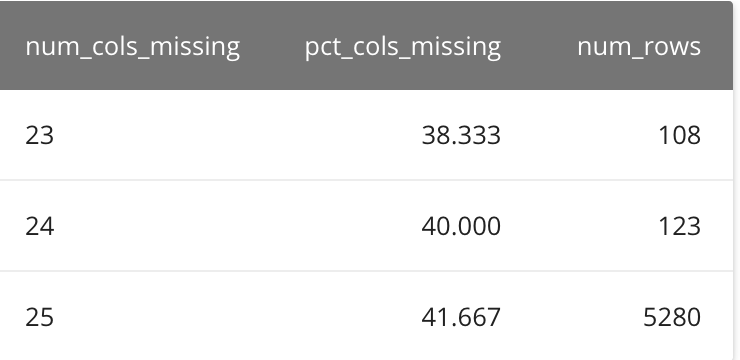

***

In [25]:
# Returns the count of null per row, but can not filter by column
# df.apply(lambda x: sum(x.isnull().values), axis = 1)
num_cols_missing = df.loc[:, df.isna().any()].count()
num_cols_missing

typeconstructiontypeid            222
storytypeid                        50
heatingorsystemtypeid           49440
buildingclasstypeid                15
architecturalstyletypeid          206
airconditioningtypeid           24953
basementsqft                       50
buildingqualitytypeid           49672
calculatedbathnbr               76772
decktypeid                        614
finishedfloor1squarefeet         6023
calculatedfinishedsquarefeet    77185
finishedsquarefeet12            73749
finishedsquarefeet13               41
finishedsquarefeet15             3009
finishedsquarefeet50             6023
finishedsquarefeet6               386
fireplacecnt                     8276
fullbathcnt                     76772
garagecarcnt                    25474
garagetotalsqft                 25474
hashottuborspa                   1538
lotsizesquarefeet               69142
poolcnt                         16137
poolsizesum                       867
pooltypeid10                      464
pooltypeid2 

In [34]:
df.loc[:].isnull().sum()

parcelid                            0
typeconstructiontypeid          77159
storytypeid                     77331
propertylandusetypeid               0
heatingorsystemtypeid           27941
buildingclasstypeid             77366
architecturalstyletypeid        77175
airconditioningtypeid           52428
basementsqft                    77331
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           27709
calculatedbathnbr                 609
decktypeid                      76767
finishedfloor1squarefeet        71358
calculatedfinishedsquarefeet      196
finishedsquarefeet12             3632
finishedsquarefeet13            77340
finishedsquarefeet15            74372
finishedsquarefeet50            71358
finishedsquarefeet6             76995
fips                                0
fireplacecnt                    69105
fullbathcnt                       609
garagecarcnt                    51907
garagetotalsqft                 51907
hashottubors

In [50]:
num_rows = df.loc[:].isnull().sum()
num_cols_missing = df.loc[:, df.isna().any()].count()
pct_cols_missing = round(df.loc[:, df.isna().any()].count() / len(df.index) * 100, 3)
missing_cols_and_rows_df = pd.DataFrame({'num_cols_missing': num_cols_missing,
                                         'pct_cols_missing': pct_cols_missing,
                                         'num_rows': num_rows})
                                         
                                        
missing_cols_and_rows_df 

,num_cols_missing,pct_cols_missing,num_rows
airconditioningdesc,24953.0,32.247,52428
airconditioningtypeid,24953.0,32.247,52428
architecturalstyledesc,206.0,0.266,77175
architecturalstyletypeid,206.0,0.266,77175
assessmentyear,NaN,NaN,0
basementsqft,50.0,0.065,77331
bathroomcnt,NaN,NaN,0
bedroomcnt,NaN,NaN,0
buildingclassdesc,15.0,0.019,77366
buildingclasstypeid,15.0,0.019,77366


### Prep Data Function:

In [14]:
# Function to Prep Data
def data_prep(df, cols_to_remove=[], prop_required_column=.5, prop_required_row=.75):
    
    def remove_columns(df, cols_to_remove):  
        df = df.drop(columns=cols_to_remove)
        return df

    def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
        threshold = int(round(prop_required_column*len(df.index),0))
        df.dropna(axis=1, thresh=threshold, inplace=True)
        threshold = int(round(prop_required_row*len(df.columns),0))
        df.dropna(axis=0, thresh=threshold, inplace=True)
        return df
    
    df = remove_columns(df, cols_to_remove)  # Removes Specified Columns
    df = handle_missing_values(df, prop_required_column, prop_required_row) # Removes Specified Rows
    #df.dropna(inplace=True) # Drops all Null Values From Dataframe
    return df


# How to Call the Function
# df = prepare.data_prep(
#     df,
#     cols_to_remove=[],
#     prop_required_column=.6,
#     prop_required_row=.75
# )